# 推特抢跑 Notebook 验证（v0.1.1）

本 Notebook 用于验证：推文 → AI 分析 → 交易对推断 → Binance 1m K 线展示 的完整流程。

- 同时展示推文 UTC 时间与本地时间（UTC+8）。
- AI 分析结果采用多行 JSON 格式输出，便于人工检查。
- 提供 `run_analysis(page: int)` 统一入口，快速切换不同推文。

In [17]:
# 配置与依赖加载
import json
from datetime import datetime, timedelta
from typing import Dict, Any, Optional, List

import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from twitter_crawler_functional_min import ai_analyze_text, LOCAL_JSON_PATH

# Binance K 线配置
BINANCE_BASE_URL = "https://api.binance.com"
BINANCE_KLINES_PATH = "/api/v3/klines"
BINANCE_INTERVAL = "1m"
WINDOW_MINUTES = 15  # 推文时间前后各 15 分钟

# Notebook 默认页码（可在下方使用 run_analysis 覆盖）
TWEET_PAGE = 0  # 使用 latest.json 中的第几条推文（data["tweets"][page]）

In [18]:
def load_single_tweet(path: str, page: int) -> Dict[str, Any]:
    """从 latest.json 中读取指定 page 的单条推文。
    - 结构遵循需求：data["tweets"][page]
    - 若顶层不是 dict，而是 list，则直接用 list[page]
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, dict):
        tweets = data.get("tweets") or data
    else:
        tweets = data
    return tweets[page]


def parse_tweet_time(tweet: Dict[str, Any]) -> datetime:
    """将推文中的 createdAt 转为 UTC datetime 对象。
    示例格式："Thu Nov 13 16:25:19 +0000 2025"
    """
    created_at = tweet.get("createdAt") or tweet.get("created_at")
    return datetime.strptime(created_at, "%a %b %d %H:%M:%S %z %Y")


def to_local_time(dt_utc: datetime, offset_hours: int = 8) -> datetime:
    """将 UTC 时间转换为本地时间（默认 UTC+8）。"""
    return dt_utc + timedelta(hours=offset_hours)

In [19]:
def call_ai_for_tweet(text: str, use_proxy: Optional[bool] = None) -> Dict[str, Any]:
    """调用已有 ai_analyze_text，对推文文本做分析并尽量解析为 JSON dict。
    - use_proxy 为 None 时，沿用全局 USE_OPENAI_PROXY 行为
    - 若 AI 返回非严格 JSON，则包装为 {"raw": 原始字符串}
    """
    raw = ai_analyze_text(text, proxy=use_proxy)
    if not raw:
        return {"raw": "(空响应)"}
    try:
        return json.loads(raw)
    except Exception:
        return {"raw": raw}


def pretty_print_ai(ai_res: Dict[str, Any]) -> None:
    """人类友好的多行打印 AI 分析结果。"""
    if "raw" in ai_res and len(ai_res) == 1:
        print("[AI RAW]")
        print(ai_res["raw"])
        return
    try:
        print("[AI JSON]")
        print(json.dumps(ai_res, ensure_ascii=False, indent=2))
    except Exception:
        print("[AI RAW/FALLBACK]")
        print(ai_res)

In [20]:
SYMBOL_MAP = {
    "BTC": "BTCUSDT",
    "ETH": "ETHUSDT",
    "BNB": "BNBUSDT",
    "SOL": "SOLUSDT",
    "DOGE": "DOGEUSDT",
}


def normalize_symbol_from_ai(ai_res: Dict[str, Any]) -> Optional[str]:
    """从 AI 结果中提取交易币种并映射为 Binance 现货 symbol。"""
    raw_symbol = ai_res.get("交易币种")
    if isinstance(raw_symbol, list) and raw_symbol:
        first = str(raw_symbol[0]).upper()
    elif isinstance(raw_symbol, str) and raw_symbol.strip():
        first = raw_symbol.strip().upper()
    else:
        return None
    base = first.replace("USDT", "").replace("/", "").upper()
    return SYMBOL_MAP.get(base)


def fallback_symbol_from_text(text: str) -> Optional[str]:
    """在 AI 无法给出交易币种时，从原始文本粗略匹配常见币种。"""
    upper = text.upper()
    for base, symbol in SYMBOL_MAP.items():
        if base in upper:
            return symbol
    return None


def detect_trade_symbol(ai_res: Dict[str, Any], text: str) -> Optional[str]:
    """综合 AI 输出与原始文本，推断最终可交易 symbol。
    - 优先 AI 输出
    - 其次文本关键词
    - 若仍无法确定，返回 None（视为不可交易）
    """
    symbol = normalize_symbol_from_ai(ai_res)
    if symbol:
        return symbol
    return fallback_symbol_from_text(text)

In [21]:
def fetch_binance_klines(symbol: str, center_time_utc: datetime,
                         minutes: int = WINDOW_MINUTES) -> List[List[Any]]:
    """获取 symbol 在 center_time 前后指定分钟窗口内的 1m K 线原始数据（使用 UTC 时间戳）。"""
    start = center_time_utc - timedelta(minutes=minutes)
    end = center_time_utc + timedelta(minutes=minutes)
    params = {
        "symbol": symbol,
        "interval": BINANCE_INTERVAL,
        "startTime": int(start.timestamp() * 1000),
        "endTime": int(end.timestamp() * 1000),
    }
    url = BINANCE_BASE_URL + BINANCE_KLINES_PATH
    resp = requests.get(url, params=params, timeout=10)
    resp.raise_for_status()
    return resp.json()


def format_klines(klines: List[List[Any]]):
    """将 Binance 原始 K 线转换为 (times, opens, highs, lows, closes)。
    times 使用本地时间（便于与本地 UTC+8 对齐）。
    """
    times, opens, highs, lows, closes = [], [], [], [], []
    for k in klines:
        ts = datetime.fromtimestamp(k[0] / 1000)
        times.append(ts)
        opens.append(float(k[1]))
        highs.append(float(k[2]))
        lows.append(float(k[3]))
        closes.append(float(k[4]))
    return times, opens, highs, lows, closes

In [22]:
def plot_candles(times, opens, highs, lows, closes,
                 tweet_time_local: datetime,
                 title: str = "",
                 tweet_time_utc: Optional[datetime] = None) -> None:
    """简单绘制 1m K 线并标出推文时间竖线。
    - X 轴：本地时间（通常为 UTC+8）
    - 图下方附加推文 UTC / 本地时间说明
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    for t, o, h, l, c in zip(times, opens, highs, lows, closes):
        color = "red" if c >= o else "green"
        ax.plot([t, t], [l, h], color=color, linewidth=1)
        ax.plot([t, t], [o, c], color=color, linewidth=4)

    ax.axvline(tweet_time_local, color="blue",
               linestyle="--", label="Tweet Time")

    if times:
        min_t, max_t = min(times), max(times)
        ax.set_xlim(min_t, max_t)

    ax.set_title(title)
    ax.set_xlabel("Time (Local, UTC+8)")
    ax.set_ylabel("Price")

    locator = mdates.AutoDateLocator()
    formatter = mdates.DateFormatter("%m-%d %H:%M")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.legend()

    if tweet_time_utc is not None:
        info = (
            f"Tweet UTC: {tweet_time_utc.strftime('%Y-%m-%d %H:%M:%S %z')}\n" 
            f"Tweet Local (UTC+8): {tweet_time_local.strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.figtext(0.01, -0.02, info, ha="left", va="top", fontsize=8)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [23]:
def run_analysis(page: int) -> None:
    """统一入口：分析 data["tweets"][page] 的完整链路。"""
    global TWEET_PAGE
    TWEET_PAGE = page
    print(f"[RUN] 分析 data['tweets'][{page}]")

    tweet = load_single_tweet(LOCAL_JSON_PATH, TWEET_PAGE)
    tweet_text = tweet.get("text") or tweet.get("full_text") or ""
    tweet_time_utc = parse_tweet_time(tweet)
    tweet_time_local = to_local_time(tweet_time_utc, 8)

    print("[TWEET ID   ]", tweet.get("id"))
    print("[CREATED UTC]", tweet.get("createdAt"))
    print("[CREATED CN ]", tweet_time_local.strftime("%Y-%m-%d %H:%M:%S (UTC+8)"))
    print("[TEXT       ]", tweet_text)

    ai_result = call_ai_for_tweet(tweet_text)
    pretty_print_ai(ai_result)

    symbol = detect_trade_symbol(ai_result, tweet_text)
    direction = ai_result.get("交易方向") or ai_result.get("direction")
    confidence = ai_result.get("消息置信度") or ai_result.get("confidence")

    print("[SYMBOL     ]", symbol)
    print("[DIRECTION  ]", direction)
    print("[CONF       ]", confidence)

    if symbol is None:
        print("[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。")
    else:
        print(f"[INFO] 获取 {symbol} 在推文时间前后 {WINDOW_MINUTES} 分钟的 1m K 线…")
        try:
            raw_klines = fetch_binance_klines(symbol, tweet_time_utc)
            if not raw_klines:
                print("[WARN] 返回 K 线为空")
            else:
                t, o, h, l, c = format_klines(raw_klines)
                title = (
                    f"{symbol} 1m K 线（本地时间，含推文时间 "
                    f"{tweet_time_local.strftime('%Y-%m-%d %H:%M')}）"
                )
                plot_candles(
                    t, o, h, l, c,
                    tweet_time_local,
                    title=title,
                    tweet_time_utc=tweet_time_utc,
                )
        except Exception as e:
            print("[ERR] 获取或绘制 K 线失败:", e)

    summary = {
        "tweet_id": tweet.get("id"),
        "created_at_utc": tweet.get("createdAt"),
        "created_at_local": tweet_time_local.isoformat(),
        "symbol": symbol,
        "direction": direction,
        "confidence": confidence,
    }
    print("[SUMMARY]", summary)

[RUN] 分析 data['tweets'][0]
[TWEET ID   ] 1989227081020944599
[CREATED UTC] Fri Nov 14 07:01:08 +0000 2025
[CREATED CN ] 2025-11-14 15:01:08 (UTC+8)
[TEXT       ] Every dip, some people think it's the end of time.

Time continues.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文为笼统情绪性表述，未提及具体币种、价位或事件，仅表达对下跌恐慌的反思，缺乏可执行的交易信息与触发因子。",
  "预期消息对市场行情影响的持续时间": "分钟",
  "消息置信度": "30"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 30
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


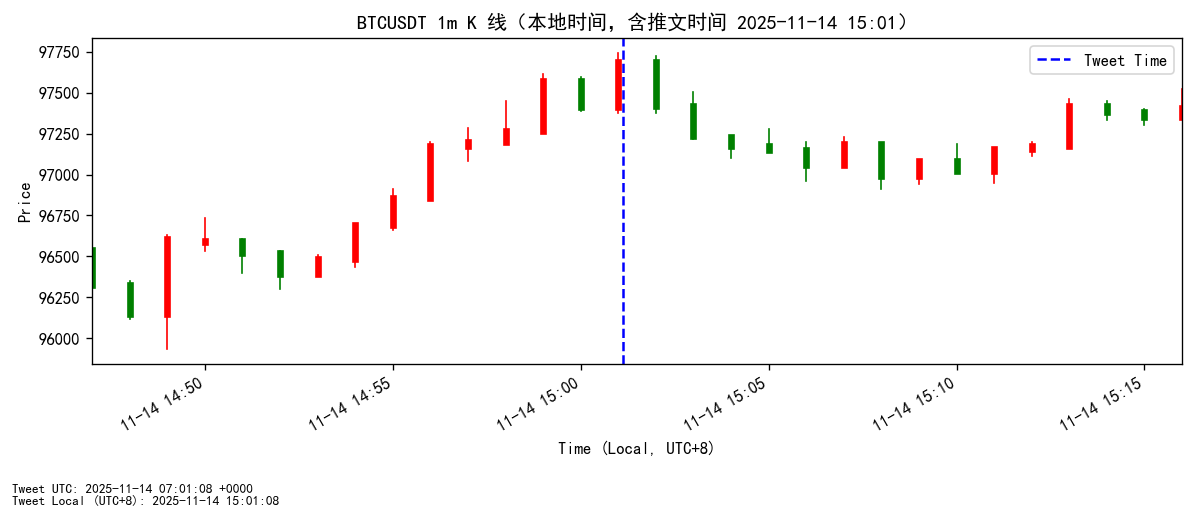

[SUMMARY] {'tweet_id': '1989227081020944599', 'created_at_utc': 'Fri Nov 14 07:01:08 +0000 2025', 'created_at_local': '2025-11-14T15:01:08+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '30'}


In [24]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0)

In [25]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(1)

[RUN] 分析 data['tweets'][1]
[TWEET ID   ] 1989006673206259821
[CREATED UTC] Thu Nov 13 16:25:19 +0000 2025
[CREATED CN ] 2025-11-14 00:25:19 (UTC+8)
[TEXT       ] Luxembourg already converted 1% of sovereign wealth fund into bitcoin.

You can get in now or after they reach 5, 10 or 50%.
[AI JSON]
{
  "分析结果": "特定币种利好",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文称卢森堡已将主权财富基金的1%转换为比特币，属于潜在的主权机构采用消息，若属实对比特币具备资金与背书层面的正面催化；同时提及未来提高至更高比例的可能性，具备预期强化效应。",
  "预期消息对市场行情影响的持续时间": "小时-天",
  "消息置信度": "45"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] long
[CONF       ] 45
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…
[ERR] 获取或绘制 K 线失败: HTTPSConnectionPool(host='api.binance.com', port=443): Max retries exceeded with url: /api/v3/klines?symbol=BTCUSDT&interval=1m&startTime=1763050219000&endTime=1763052019000 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1016)')))
[SUMMARY] {'tweet_id': '1989006673206259821', 'cre

[RUN] 分析 data['tweets'][2]
[TWEET ID   ] 1988965634919821724
[CREATED UTC] Thu Nov 13 13:42:15 +0000 2025
[CREATED CN ] 2025-11-13 21:42:15 (UTC+8)
[TEXT       ] CNB needs some BNB. 🤷‍♂️😆
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BNB"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为模糊玩笑式表述“CNB需要一些BNB”，无权威主体、无时间点、无事件性质（如上币、合作、增持）与来源佐证，无法构成可交易的实质性利好或利空。",
  "预期消息对市场行情影响的持续时间": "1分钟",
  "消息置信度": "25"
}
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 25
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


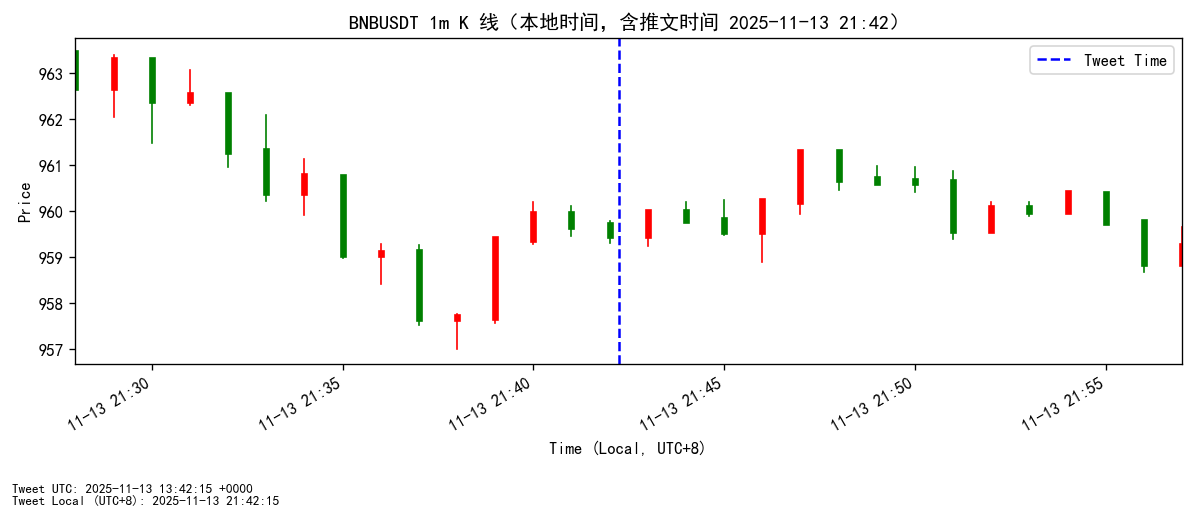

[SUMMARY] {'tweet_id': '1988965634919821724', 'created_at_utc': 'Thu Nov 13 13:42:15 +0000 2025', 'created_at_local': '2025-11-13T21:42:15+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '25'}


In [26]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(2)、run_analysis(2) 等等
run_analysis(2)

[RUN] 分析 data['tweets'][3]
[TWEET ID   ] 1988883673144336473
[CREATED UTC] Thu Nov 13 08:16:34 +0000 2025
[CREATED CN ] 2025-11-13 16:16:34 (UTC+8)
[TEXT       ] Writing the book made me realize my English is poor, very poor.

Reviewing the Chinese translations by my colleagues made me realize my Chinese is non-existent. Had to use the dictionary constantly.

Basically, I don't really speak any language. 😂
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为作者自嘲语言能力的个人感悟，无涉及加密市场、项目进展、监管、资金流或价格相关信息，未包含情绪或事件驱动信号，对市场无直接影响",
  "预期消息对市场行情影响的持续时间": "无",
  "消息置信度": "95"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 95
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


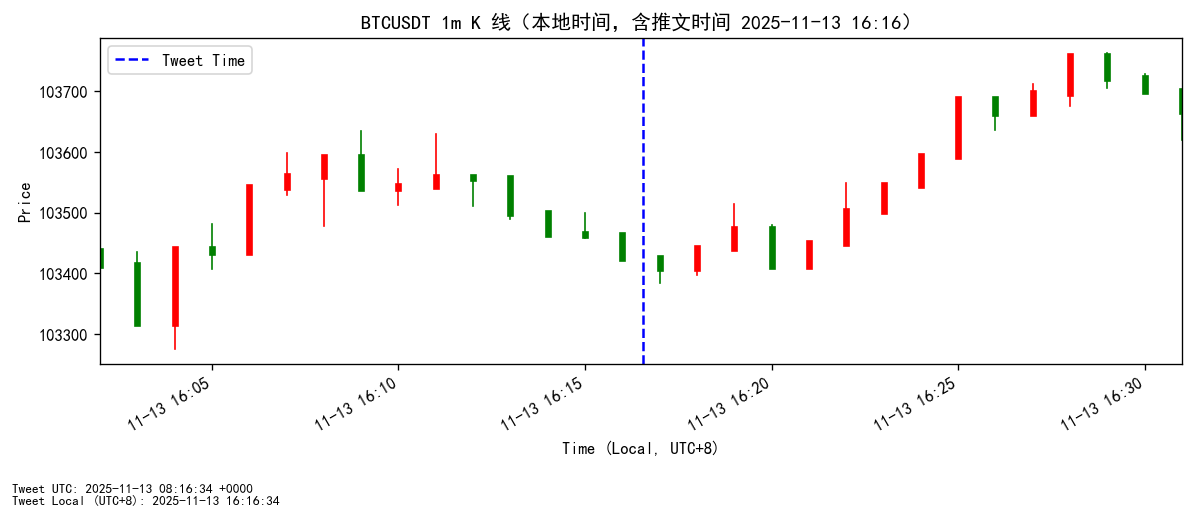

[SUMMARY] {'tweet_id': '1988883673144336473', 'created_at_utc': 'Thu Nov 13 08:16:34 +0000 2025', 'created_at_local': '2025-11-13T16:16:34+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '95'}


In [27]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(3)

[RUN] 分析 data['tweets'][4]
[TWEET ID   ] 1988882745989153243
[CREATED UTC] Thu Nov 13 08:12:52 +0000 2025
[CREATED CN ] 2025-11-13 16:12:52 (UTC+8)
[TEXT       ] Help me with some arguments? 👇😂
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为“Help me with some arguments? 👇😂”，未包含任何与加密货币、价格、事件或链上数据相关的具体信息或指向，无法判断对市场或特定币种的影响",
  "预期消息对市场行情影响的持续时间": "无",
  "消息置信度": "10"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 10
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


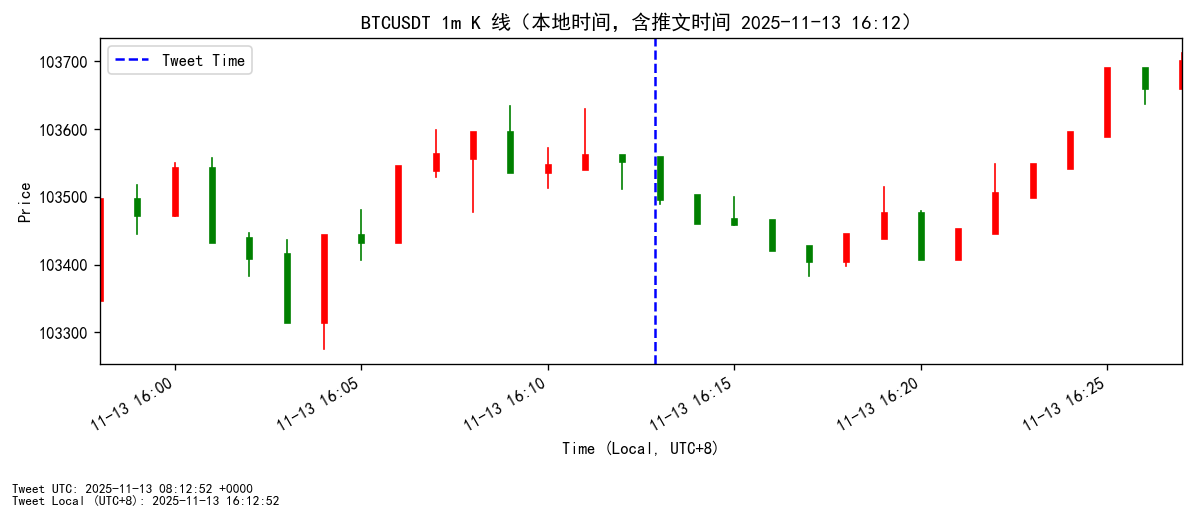

[SUMMARY] {'tweet_id': '1988882745989153243', 'created_at_utc': 'Thu Nov 13 08:12:52 +0000 2025', 'created_at_local': '2025-11-13T16:12:52+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '10'}


In [28]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(4)

[RUN] 分析 data['tweets'][5]
[TWEET ID   ] 1988689709045047579
[CREATED UTC] Wed Nov 12 19:25:49 +0000 2025
[CREATED CN ] 2025-11-13 03:25:49 (UTC+8)
[TEXT       ] Our intern tells me that 60% of the comments under my posts are likely AI generated or assisted. Same for Elon Musk's posts.

He used AI to do the analysis...
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC",
    "DOGE"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅讨论社交平台评论中AI生成内容比例上升，并无具体与区块链/加密资产基本面、政策或大型机构动作直接相关的信息。该类话题更偏向社交情绪与平台生态讨论，缺乏对价格形成明确的正负催化。即使涉及Elon Musk相关讨论，亦未出现对其发币或市场观点的实质性信号。",
  "预期消息对市场行情影响的持续时间": "分钟",
  "消息置信度": "62"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 62
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


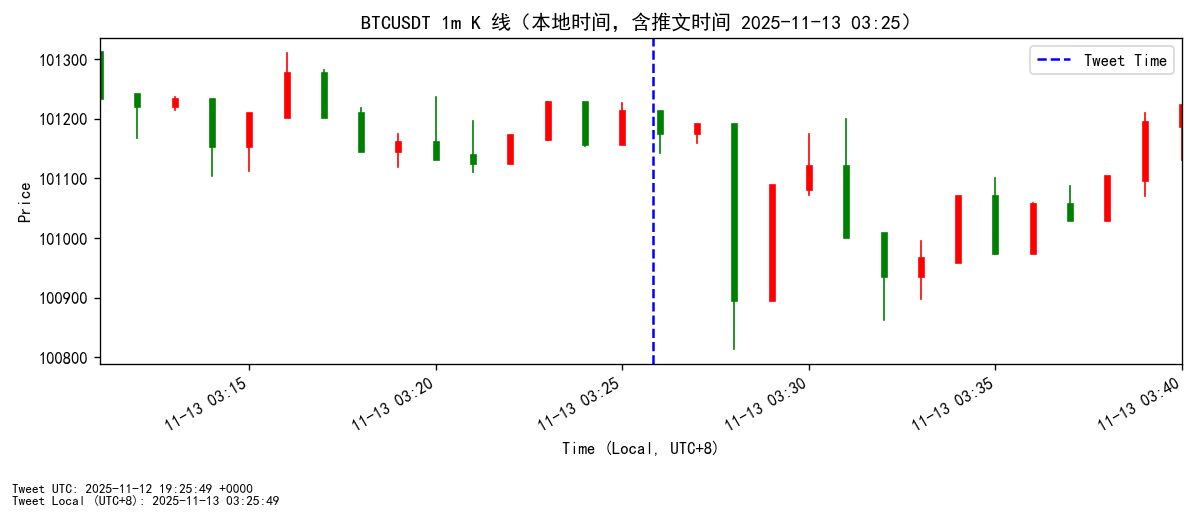

[SUMMARY] {'tweet_id': '1988689709045047579', 'created_at_utc': 'Wed Nov 12 19:25:49 +0000 2025', 'created_at_local': '2025-11-13T03:25:49+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '62'}


In [29]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(5)

[RUN] 分析 data['tweets'][6]
[TWEET ID   ] 1988519142819872810
[CREATED UTC] Wed Nov 12 08:08:03 +0000 2025
[CREATED CN ] 2025-11-12 16:08:03 (UTC+8)
[TEXT       ] RT @eleanorshughes1: Glad to see the Ontario Court of Appeal set aside an Ontario Securities Commission document demand it described as “st…
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC",
    "ETH"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅称安大略省上诉法院撤销了安省证监会（OSC）一份被形容为“过度”的文件要求，属法律/执法程序层面的进展，未直接涉及加密货币政策放松、ETF审批、交易限制解除或对具体加密项目的裁决；缺乏对加密资产价格产生即刻影响的实质性催化。",
  "预期消息对市场行情影响的持续时间": "分钟",
  "消息置信度": "45"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 45
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


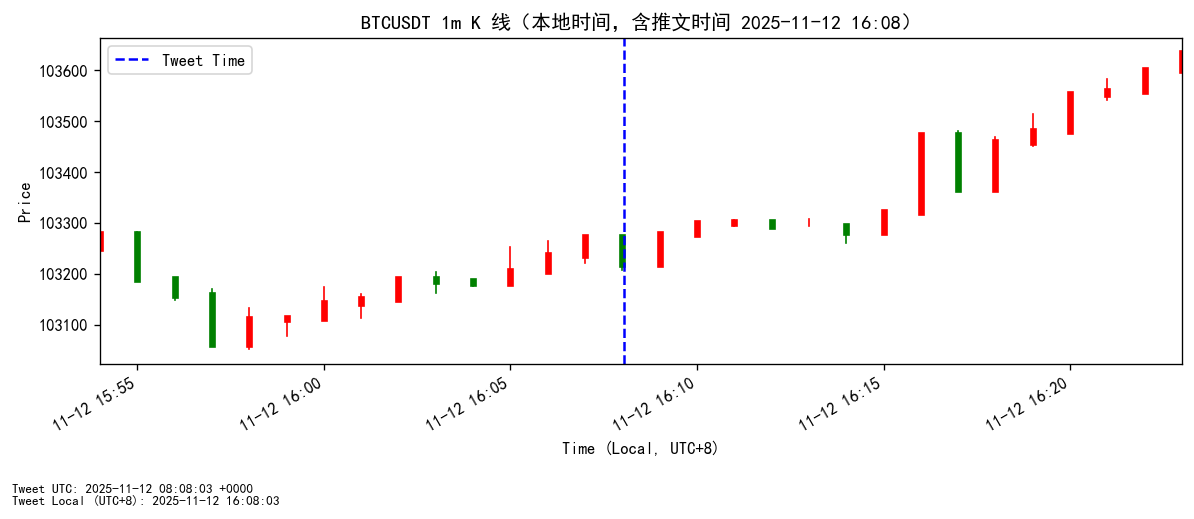

[SUMMARY] {'tweet_id': '1988519142819872810', 'created_at_utc': 'Wed Nov 12 08:08:03 +0000 2025', 'created_at_local': '2025-11-12T16:08:03+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '45'}


In [30]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(6)

[RUN] 分析 data['tweets'][7]
[TWEET ID   ] 1988216302952124890
[CREATED UTC] Tue Nov 11 12:04:40 +0000 2025
[CREATED CN ] 2025-11-11 20:04:40 (UTC+8)
[TEXT       ] This is NOT my book. Beware of scammers using AI to make fake books. 🤣 https://t.co/FXcHKbGf5O
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅提醒存在AI假书诈骗，与加密项目、代币基本面或价格催化无直接关联；未提及任何币种或市场事件，短期对行情影响中性",
  "预期消息对市场行情影响的持续时间": "分钟",
  "消息置信度": "78"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 78
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


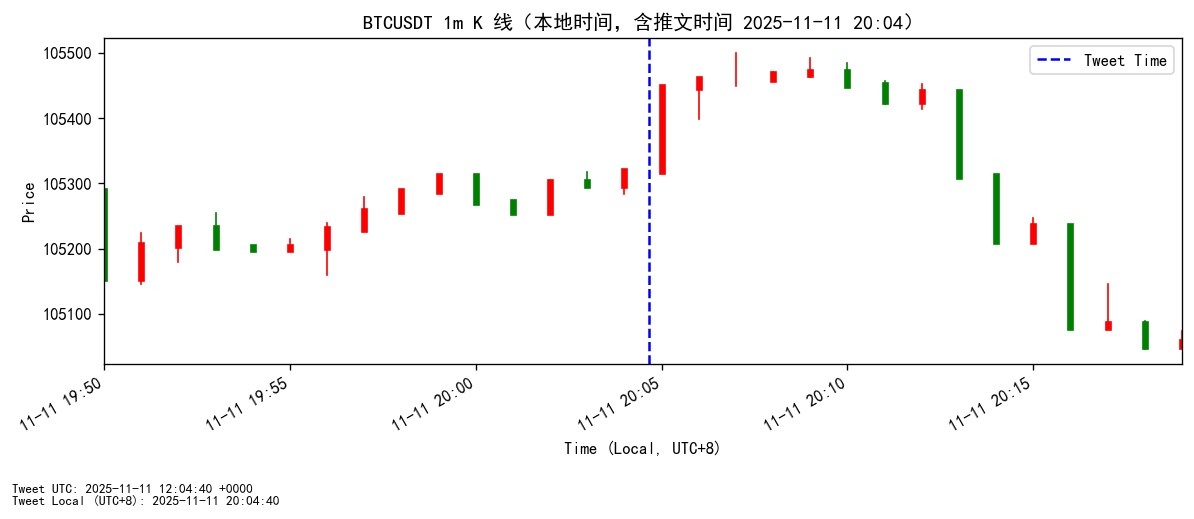

[SUMMARY] {'tweet_id': '1988216302952124890', 'created_at_utc': 'Tue Nov 11 12:04:40 +0000 2025', 'created_at_local': '2025-11-11T20:04:40+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '78'}


In [31]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(7)

[RUN] 分析 data['tweets'][8]
[TWEET ID   ] 1988110086280253660
[CREATED UTC] Tue Nov 11 05:02:36 +0000 2025
[CREATED CN ] 2025-11-11 13:02:36 (UTC+8)
[TEXT       ] RT @binance: Introducing Crypto Trade Analyzer! 

Compare real-time trading costs across top exchanges. Customize fees &amp; spot your cost-eff…
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BNB",
    "BTC",
    "ETH"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文为Binance推广新的交易成本对比工具（Crypto Trade Analyzer），属于产品功能更新/营销信息，未涉及具体币种基本面变化、监管利空/利好或链上数据与资金流入等可量化利多/利空信号。短期内可能提升交易活跃度与费率敏感度，但对单一币种无直接方向性影响。",
  "预期消息对市场行情影响的持续时间": "小时",
  "消息置信度": "72"
}
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 72
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


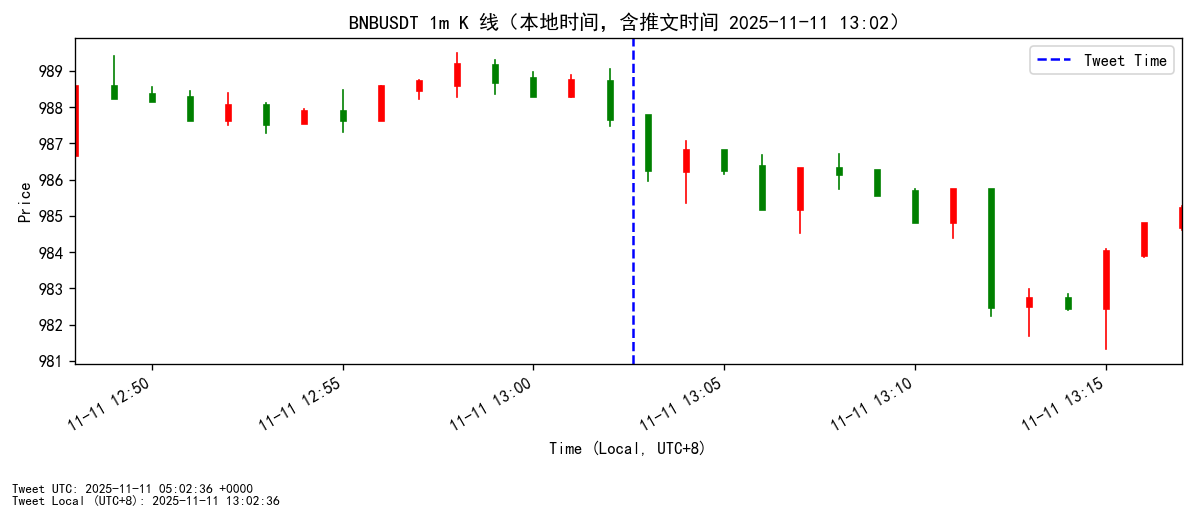

[SUMMARY] {'tweet_id': '1988110086280253660', 'created_at_utc': 'Tue Nov 11 05:02:36 +0000 2025', 'created_at_local': '2025-11-11T13:02:36+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '72'}


In [32]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(8)

[RUN] 分析 data['tweets'][9]
[TWEET ID   ] 1987881995402113260
[CREATED UTC] Mon Nov 10 13:56:15 +0000 2025
[CREATED CN ] 2025-11-10 21:56:15 (UTC+8)
[TEXT       ] #BNB
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BNB"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "仅有标签#BNB，未提供任何价格、事件、情绪或基本面信息，无法判断利好或利空",
  "预期消息对市场行情影响的持续时间": "1分钟",
  "消息置信度": "5"
}
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 5
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


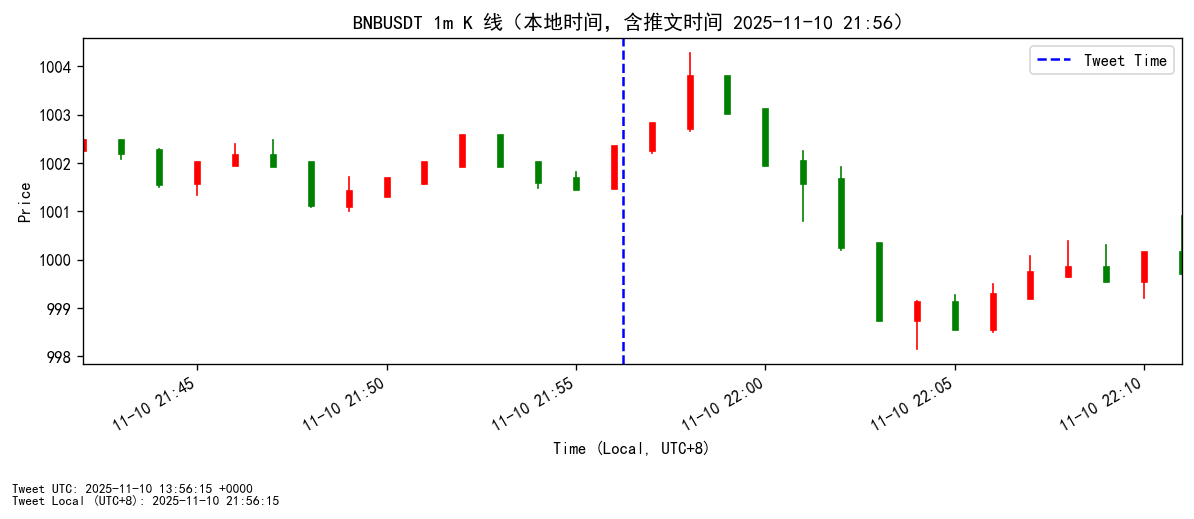

[SUMMARY] {'tweet_id': '1987881995402113260', 'created_at_utc': 'Mon Nov 10 13:56:15 +0000 2025', 'created_at_local': '2025-11-10T21:56:15+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '5'}


In [33]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(9)

[RUN] 分析 data['tweets'][10]
[TWEET ID   ] 1987875167780118728
[CREATED UTC] Mon Nov 10 13:29:07 +0000 2025
[CREATED CN ] 2025-11-10 21:29:07 (UTC+8)
[TEXT       ] I might have contributed a tiny bit to Kazakhstan's launching of $1 billion crypto reserve fund. 😆
 https://t.co/vquLAjmL72
[AI JSON]
{
  "分析结果": "市场整体利好",
  "交易币种": [
    "BTC",
    "ETH",
    "BNB"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文称哈萨克斯坦将启动10亿美元规模的加密储备基金，属宏观资金入场与合规/主权背书信号，对整体加密市场风险偏好构成提振；未指向特定项目，通常首先利多于流动性与避险属性更强的主流币（BTC、ETH），交易所相关生态（BNB）亦受益。",
  "预期消息对市场行情影响的持续时间": "天",
  "消息置信度": "58"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] long
[CONF       ] 58
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


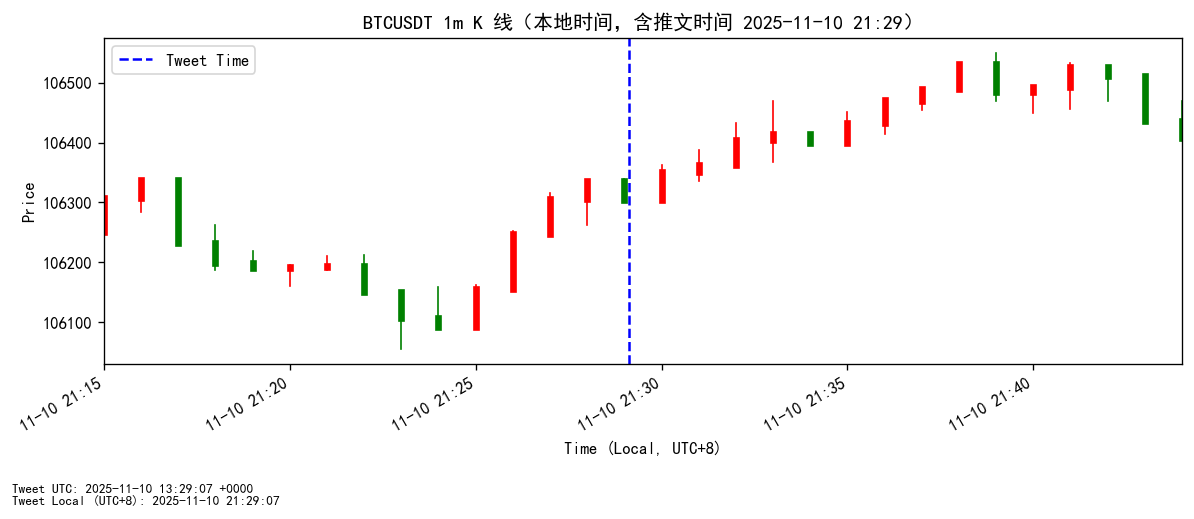

[SUMMARY] {'tweet_id': '1987875167780118728', 'created_at_utc': 'Mon Nov 10 13:29:07 +0000 2025', 'created_at_local': '2025-11-10T21:29:07+00:00', 'symbol': 'BTCUSDT', 'direction': 'long', 'confidence': '58'}


In [34]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(10)

[RUN] 分析 data['tweets'][11]
[TWEET ID   ] 1987786698538012685
[CREATED UTC] Mon Nov 10 07:37:34 +0000 2025
[CREATED CN ] 2025-11-10 15:37:34 (UTC+8)
[TEXT       ] Don't buy handles that I follow. I will unfollow any sold accounts. If you see an account for sale, let me know. DM, tweet, notify "interns".

I follow accounts "randomly", usually supportive, informative, positive energy people.

My follow means nothing, not endorsement.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容仅为账号主声明其关注与取关规则，强调关注不代表背书，与任何特定加密货币、项目或市场催化无直接关联，不构成基本面或情绪面的实质利多/利空信号。对市场的边际影响极弱且短暂。",
  "预期消息对市场行情影响的持续时间": "分钟",
  "消息置信度": "85"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 85
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


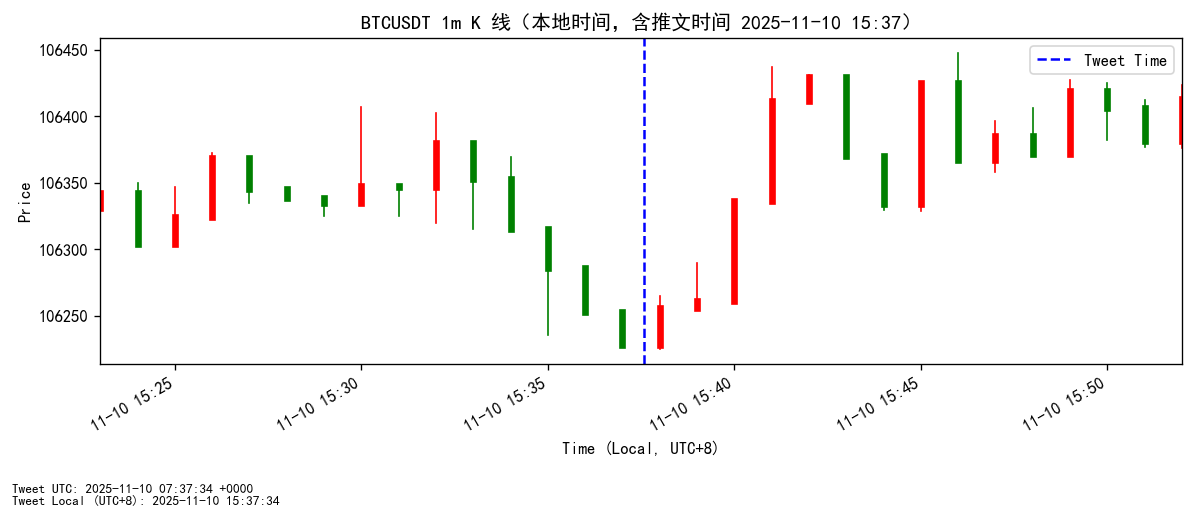

[SUMMARY] {'tweet_id': '1987786698538012685', 'created_at_utc': 'Mon Nov 10 07:37:34 +0000 2025', 'created_at_local': '2025-11-10T15:37:34+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '85'}


In [35]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(11)

In [36]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(12)

[RUN] 分析 data['tweets'][12]
[TWEET ID   ] 1987497485401780261
[CREATED UTC] Sun Nov 09 12:28:21 +0000 2025
[CREATED CN ] 2025-11-09 20:28:21 (UTC+8)
[TEXT       ] Nothing much. I unfollow mostly inactive accounts once in a while. 🤷‍♂️😂
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅表示作者偶尔取关不活跃账号，未涉及任何加密货币、项目、价格、宏观或链上信息，也无情绪指引或市场信号，无法形成可交易结论",
  "预期消息对市场行情影响的持续时间": "无",
  "消息置信度": "95"
}
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 95
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987497485401780261', 'created_at_utc': 'Sun Nov 09 12:28:21 +0000 2025', 'created_at_local': '2025-11-09T20:28:21+00:00', 'symbol': None, 'direction': '观望', 'confidence': '95'}


[RUN] 分析 data['tweets'][13]
[TWEET ID   ] 1987480267884318963
[CREATED UTC] Sun Nov 09 11:19:56 +0000 2025
[CREATED CN ] 2025-11-09 19:19:56 (UTC+8)
[TEXT       ] RT @joyhodling: Who owes the United States and other countries debt?

How does the system operate?

Who is believed to have designed or inf…
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容为转推，讨论宏观层面的债务与金融系统设计的疑问句，未包含具体加密货币、价格水平或政策变动等可交易信号，缺乏直接利多或利空信息",
  "预期消息对市场行情影响的持续时间": "分钟",
  "消息置信度": "25"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 25
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


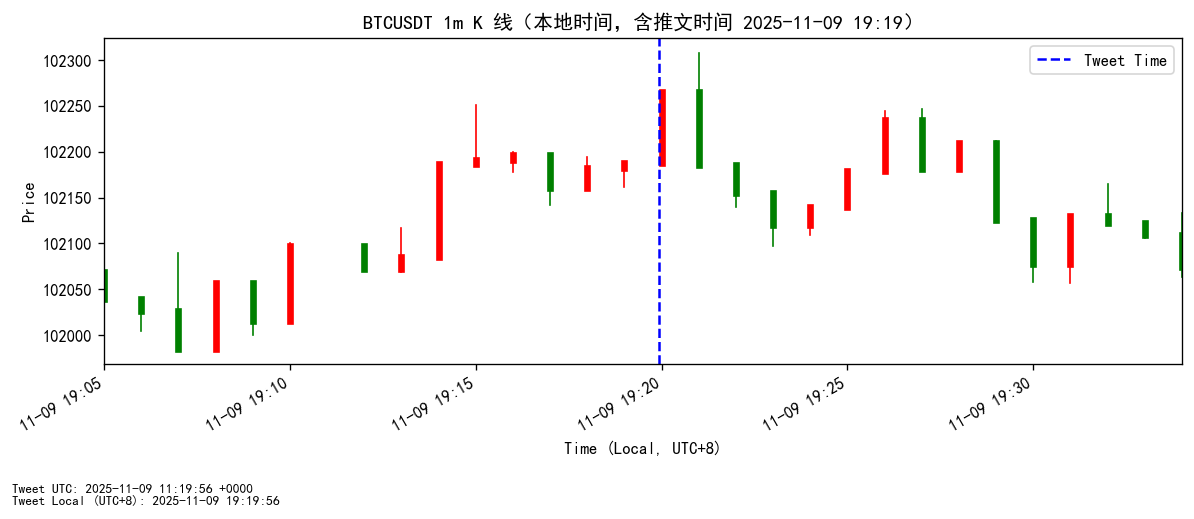

[SUMMARY] {'tweet_id': '1987480267884318963', 'created_at_utc': 'Sun Nov 09 11:19:56 +0000 2025', 'created_at_local': '2025-11-09T19:19:56+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '25'}


In [37]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(13)

[RUN] 分析 data['tweets'][14]
[TWEET ID   ] 1987454778650300870
[CREATED UTC] Sun Nov 09 09:38:39 +0000 2025
[CREATED CN ] 2025-11-09 17:38:39 (UTC+8)
[TEXT       ] Just cleaning up the wallet. The donation address only keeps #BNB. Next time, I might choose to market sell any meme coins received.

Do not send tokens to the address if you don't want them to be sold on the market
[AI JSON]
{
  "分析结果": "特定币种利空",
  "交易币种": [
    "meme板块综合",
    "BNB"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "发文者表示捐赠地址只保留BNB，收到的meme代币可能会直接在市场抛售，并提醒不想被卖就不要转入。这对未指明具体名称的meme代币形成抛压预期，可能引发流动性较弱的小盘meme币短期下跌；对BNB为中性略偏稳，因为仅保留BNB并不构成新增买盘或卖压。",
  "预期消息对市场行情影响的持续时间": "小时",
  "消息置信度": "72"
}
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 72
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


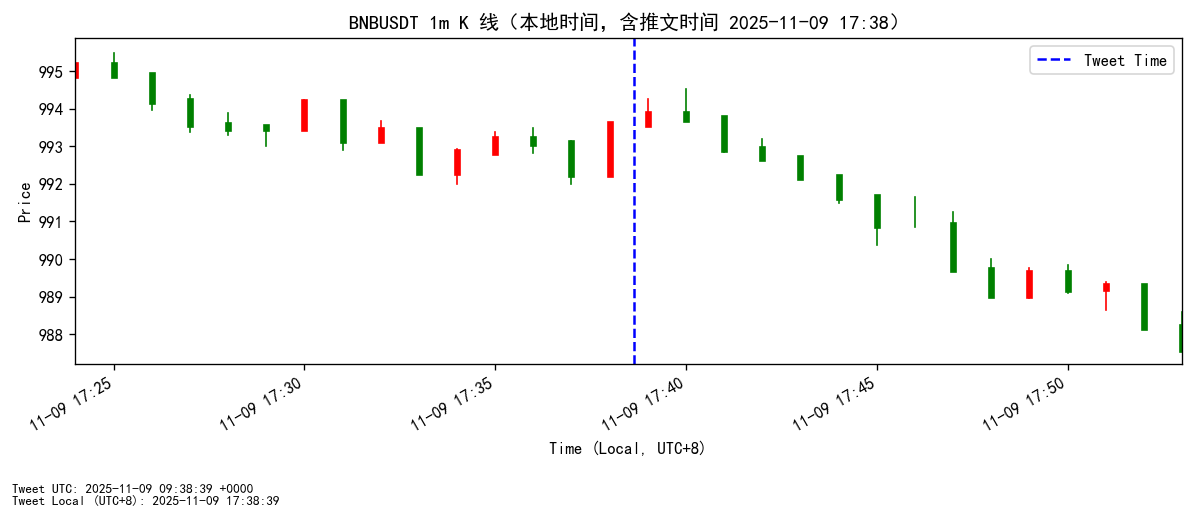

[SUMMARY] {'tweet_id': '1987454778650300870', 'created_at_utc': 'Sun Nov 09 09:38:39 +0000 2025', 'created_at_local': '2025-11-09T17:38:39+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '72'}


In [38]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(14)

[RUN] 分析 data['tweets'][15]
[TWEET ID   ] 1987429930037309496
[CREATED UTC] Sun Nov 09 07:59:54 +0000 2025
[CREATED CN ] 2025-11-09 15:59:54 (UTC+8)
[TEXT       ] I once saw on a t-shirt (from my first day in college, at orientation, 30 years ago) 🤣:

It's hard to be good; It's good to be hard.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为个人趣味性格言，无涉及任何加密货币、区块链项目、宏观政策或市场事件，缺乏可量化的交易信号与情绪催化。",
  "预期消息对市场行情影响的持续时间": "无",
  "消息置信度": "95"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] 观望
[CONF       ] 95
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


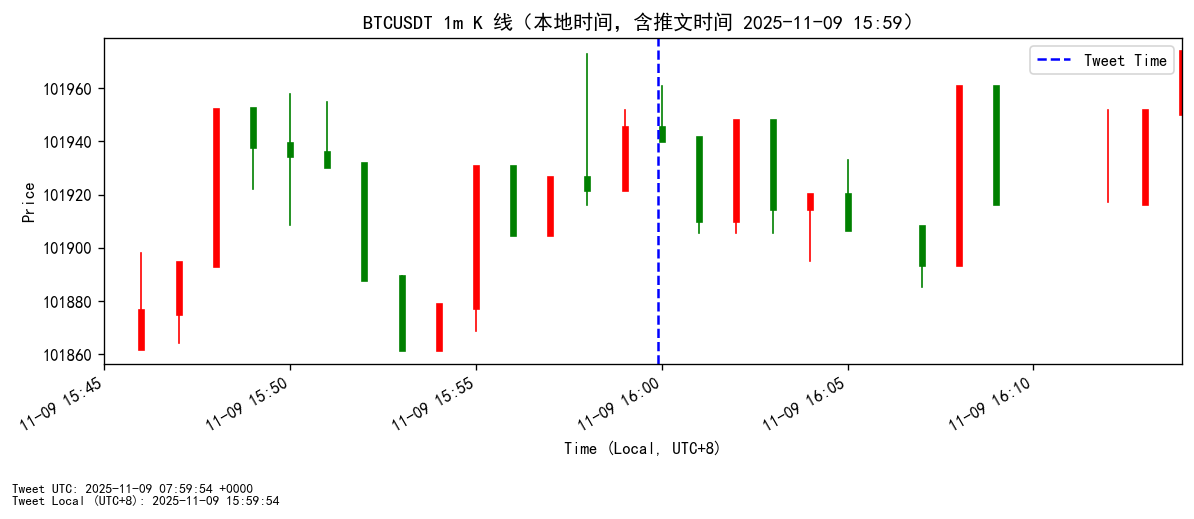

[SUMMARY] {'tweet_id': '1987429930037309496', 'created_at_utc': 'Sun Nov 09 07:59:54 +0000 2025', 'created_at_local': '2025-11-09T15:59:54+00:00', 'symbol': 'BTCUSDT', 'direction': '观望', 'confidence': '95'}


In [39]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(15)

[RUN] 分析 data['tweets'][16]
[TWEET ID   ] 1987427871347122431
[CREATED UTC] Sun Nov 09 07:51:43 +0000 2025
[CREATED CN ] 2025-11-09 15:51:43 (UTC+8)
[TEXT       ] In my advisor role to governments, last week, two senior officials from two different countries referred to crypto as "the hard money". The realization is finally happening. 💪
[AI JSON]
{
  "分析结果": "市场整体利好",
  "交易币种": [
    "BTC",
    "ETH"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "两国高级官员将加密货币称为“硬通货”，代表政策与宏观叙事层面的认可度上升，强化比特币等主流资产的价值储藏属性预期，提升风险偏好与资金流入概率，属中期情绪与叙事利好。",
  "预期消息对市场行情影响的持续时间": "天",
  "消息置信度": "65"
}
[SYMBOL     ] BTCUSDT
[DIRECTION  ] long
[CONF       ] 65
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


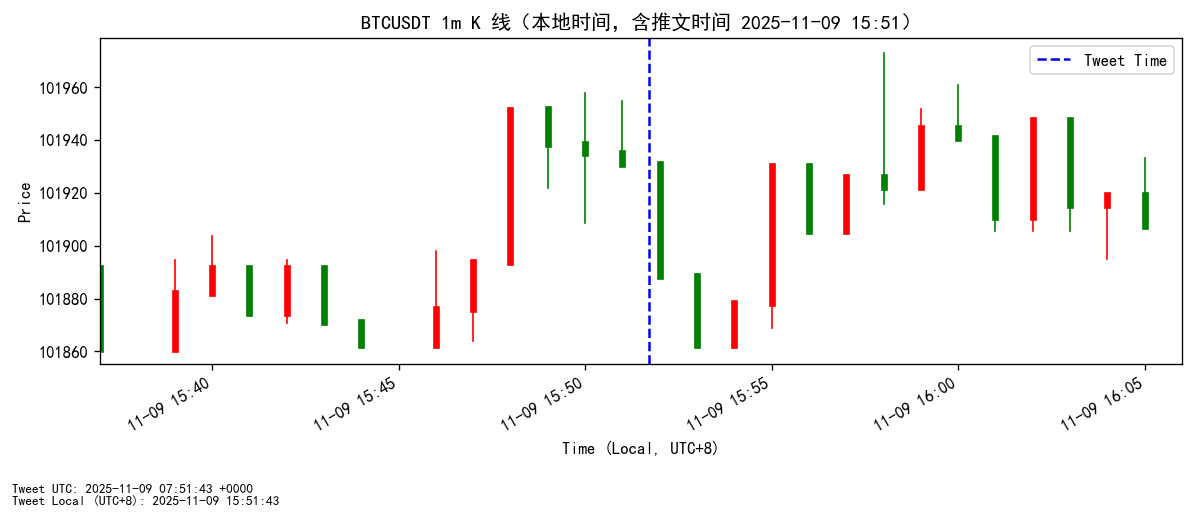

[SUMMARY] {'tweet_id': '1987427871347122431', 'created_at_utc': 'Sun Nov 09 07:51:43 +0000 2025', 'created_at_local': '2025-11-09T15:51:43+00:00', 'symbol': 'BTCUSDT', 'direction': 'long', 'confidence': '65'}


In [40]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(16)

In [41]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(17)

[RUN] 分析 data['tweets'][17]
[TWEET ID   ] 1987197598021881984
[CREATED UTC] Sat Nov 08 16:36:42 +0000 2025
[CREATED CN ] 2025-11-09 00:36:42 (UTC+8)
[TEXT       ] Spent the last couple of weeks running through the final edits on my book/memoir. Nearly done. Need a cover design. Any suggestions? 👇
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅提及作者个人书籍/回忆录的最终编辑和封面设计建议，与加密货币、区块链项目进展、政策监管、市场资金流或关键价格水平无直接关联，不构成可交易的市场信号。",
  "预期消息对市场行情影响的持续时间": "无",
  "消息置信度": "95"
}
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 95
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987197598021881984', 'created_at_utc': 'Sat Nov 08 16:36:42 +0000 2025', 'created_at_local': '2025-11-09T00:36:42+00:00', 'symbol': None, 'direction': '观望', 'confidence': '95'}


In [42]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(18)

[RUN] 分析 data['tweets'][18]
[TWEET ID   ] 1987127569695842625
[CREATED UTC] Sat Nov 08 11:58:26 +0000 2025
[CREATED CN ] 2025-11-08 19:58:26 (UTC+8)
[TEXT       ] Did you know you can create your own storybooks for your kids on @GiggleAcademy?
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容仅为@GiggleAcademy相关的功能介绍（为孩子创建故事书），未涉及任何加密货币、代币发行、合作、融资、链上集成或行业利好/利空信息，无法对加密市场或特定币种产生直接可量化影响。",
  "预期消息对市场行情影响的持续时间": "无",
  "消息置信度": "95"
}
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 95
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987127569695842625', 'created_at_utc': 'Sat Nov 08 11:58:26 +0000 2025', 'created_at_local': '2025-11-08T19:58:26+00:00', 'symbol': None, 'direction': '观望', 'confidence': '95'}


[RUN] 分析 data['tweets'][19]
[TWEET ID   ] 1987069115698454734
[CREATED UTC] Sat Nov 08 08:06:09 +0000 2025
[CREATED CN ] 2025-11-08 16:06:09 (UTC+8)
[TEXT       ] Busy week in Abu Dhabi/Dubai in early Dec. BBW (#Binance Blockchain Week) happening earlier in the week on Dec 3-4 too. Plus F1.

Yes, I promote all conferences. No competition in pushing adoption.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BNB",
    "BTC",
    "ETH"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅提及12月初阿布扎比/迪拜将举办Binance Blockchain Week与F1，强调推广会议、无竞争推动采用。未包含政策利好、合作落地、上币、资金注入或数据指标等可量化催化，仅属活动预热与情绪性话题，对价格影响弱且不具备即时交易信号。对BNB存在轻微品牌/生态曝光利好，但强度与时效均有限。",
  "预期消息对市场行情影响的持续时间": "小时",
  "消息置信度": "62"
}
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 62
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


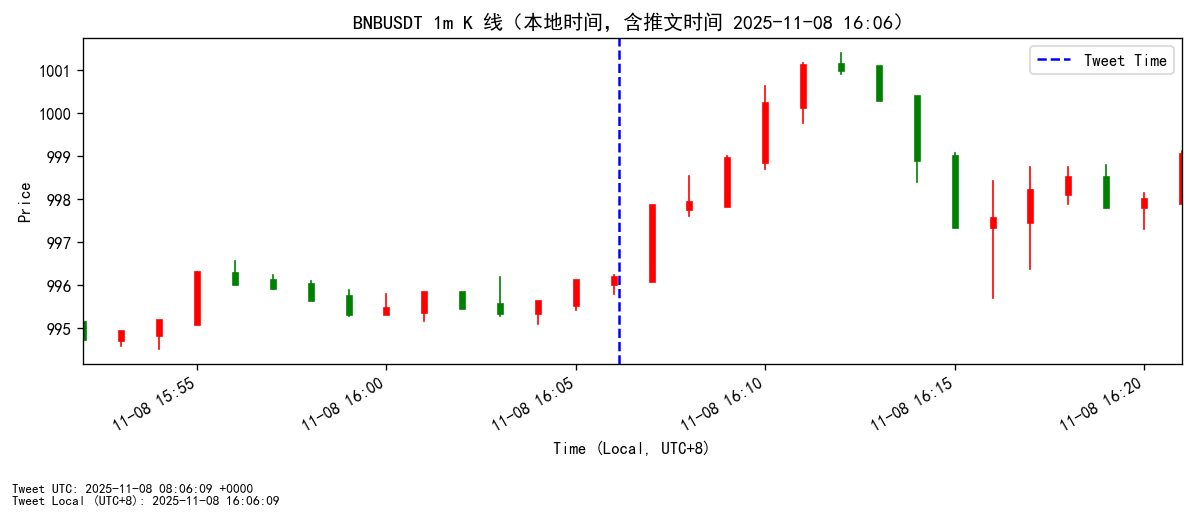

[SUMMARY] {'tweet_id': '1987069115698454734', 'created_at_utc': 'Sat Nov 08 08:06:09 +0000 2025', 'created_at_local': '2025-11-08T16:06:09+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '62'}


In [43]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(19)